In [34]:
# Cell 1: 配置
import os
import sys

# --- 请在此处修改您的路径 ---

# 1. 指向您新创建的预处理脚本
PREPROCESS_SCRIPT_PATH = "/home1/jijh/diffusion_project/ADiffusion/src/pipeline/preprocess_graphs_for_diffusion.py" # <--- 必须修改

# 2. 包含原始图文件的目录 (输入)
#    这些文件应该包含 `latent_paths` 属性
ORIGINAL_GRAPH_DIR = "/cwStorage/nodecw_group/jijh/hest_graph_data_pca50_knn6" # <--- 必须修改

# 3. 将保存新的、增强的图文件的目录 (输出)
OUTPUT_DIR_FOR_DIFFUSION = "/cwStorage/nodecw_group/jijh/hest_graph_data_with_vae_latents" # <--- 必须修改

# 4. 配置并发工作线程数
#    这个值取决于您的存储性能和CPU。对于快速的NVMe SSD，32或64可能效果很好。对于网络存储，16-32通常是安全的起点。
NUM_WORKERS = 32

# --- 结束配置 ---


# 创建输出目录（如果不存在）
os.makedirs(OUTPUT_DIR_FOR_DIFFUSION, exist_ok=True)

# 打印配置以供确认
print("--- 快速预处理配置 ---")
print(f"将要执行的脚本: {PREPROCESS_SCRIPT_PATH}")
print(f"原始图数据源: {ORIGINAL_GRAPH_DIR}")
print(f"处理后数据输出到: {OUTPUT_DIR_FOR_DIFFUSION}")
print(f"将使用的工作线程数: {NUM_WORKERS}")
print("-" * 20)

# 检查脚本是否存在
if not os.path.exists(PREPROCESS_SCRIPT_PATH):
    print(f"错误：找不到预处理脚本 '{PREPROCESS_SCRIPT_PATH}'。请检查路径。")

--- 快速预处理配置 ---
将要执行的脚本: /home1/jijh/diffusion_project/ADiffusion/src/pipeline/preprocess_graphs_for_diffusion.py
原始图数据源: /cwStorage/nodecw_group/jijh/hest_graph_data_pca50_knn6
处理后数据输出到: /cwStorage/nodecw_group/jijh/hest_graph_data_with_vae_latents
将使用的工作线程数: 32
--------------------


In [35]:
# Cell 2: 执行快速预处理脚本

# 检查脚本路径是否已设置
if not os.path.exists(PREPROCESS_SCRIPT_PATH):
    print("错误：请先在上面的单元格中设置正确的 PREPROCESS_SCRIPT_PATH。")
else:
    # 使用 `!` 在 notebook 中执行命令行指令
    # 我们将所有参数传递给脚本，包括新的 --num_workers
    !python {PREPROCESS_SCRIPT_PATH} \
        --input_dir {ORIGINAL_GRAPH_DIR} \
        --output_dir {OUTPUT_DIR_FOR_DIFFUSION} \
        --num_workers {NUM_WORKERS}

--- 开始为Diffusion模型进行快速（多线程）预处理 ---
源目录: /cwStorage/nodecw_group/jijh/hest_graph_data_pca50_knn6
输出目录: /cwStorage/nodecw_group/jijh/hest_graph_data_with_vae_latents
使用的工作线程数: 32
/home1/jijh/diffusion_project/ADiffusion/src/pipeline/preprocess_graphs_for_diffusion.py:40: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use ca

In [36]:
# Cell 3: 验证输出结果（与之前相同，无需修改）
import torch
import glob

print("--- 正在验证输出文件 ---")

# 检查输出目录是否为空
output_files = glob.glob(os.path.join(OUTPUT_DIR_FOR_DIFFUSION, "*_graph.pt"))
if not output_files:
    print(f"错误：输出目录 '{OUTPUT_DIR_FOR_DIFFUSION}' 为空。预处理可能失败了。")
else:
    print(f"在输出目录中找到了 {len(output_files)} 个图文件。")
    
    # 随机选择一个文件进行抽查
    test_file_path = output_files[0]
    print(f"\n正在抽查文件: {os.path.basename(test_file_path)}")
    
    try:
        augmented_data = torch.load(test_file_path, map_location='cpu')
        
        # 1. 检查新的 'latent' 属性是否存在
        if hasattr(augmented_data, 'latent'):
            print(f"✔️ 成功：找到了 'latent' 属性。")
            # 2. 检查 'latent' 的维度是否与节点数匹配
            num_nodes = augmented_data.num_nodes
            latent_shape = augmented_data.latent.shape
            print(f"  - 图中节点数: {num_nodes}")
            print(f"  - Latent 张量形状: {latent_shape}")
            if latent_shape[0] == num_nodes:
                print(f"✔️ 成功：Latent 的第一个维度 ({latent_shape[0]}) 与节点数 ({num_nodes}) 匹配。")
            else:
                print(f"❌ 失败：Latent 的维度与节点数不匹配！")
        else:
            print(f"❌ 失败：未找到 'latent' 属性！")
            
        # 3. 检查 'sample_id' 属性是否存在
        if hasattr(augmented_data, 'sample_id'):
            print(f"✔️ 成功：找到了 'sample_id' 属性，值为 '{augmented_data.sample_id}'。")
        else:
            print(f"❌ 失败：未找到 'sample_id' 属性！")

    except Exception as e:
        print(f"错误：加载或验证文件 '{os.path.basename(test_file_path)}' 时出错: {e}")

--- 正在验证输出文件 ---
在输出目录中找到了 172 个图文件。

正在抽查文件: NCBI388_graph.pt
✔️ 成功：找到了 'latent' 属性。
  - 图中节点数: 546
  - Latent 张量形状: torch.Size([546, 4, 64, 64])
✔️ 成功：Latent 的第一个维度 (546) 与节点数 (546) 匹配。
✔️ 成功：找到了 'sample_id' 属性，值为 'NCBI388'。


tensor([[[[ 2.7812e+00,  2.3750e+00,  2.4219e+00,  ...,  1.1797e+00,
           -1.0781e+00, -1.0625e+00],
          [ 3.0938e+00,  2.0469e+00,  1.8672e+00,  ...,  3.2812e-01,
           -1.4648e-03,  1.6094e+00],
          [ 2.8281e+00,  1.8906e+00,  3.1406e+00,  ...,  9.2969e-01,
           -1.3281e-01,  6.3281e-01],
          ...,
          [ 2.9062e+00,  7.1094e-01,  5.0049e-02,  ...,  6.8750e-01,
           -2.7734e-01, -7.0312e-01],
          [ 2.9219e+00,  5.7422e-01, -3.2227e-01,  ..., -7.8125e-03,
            1.9766e+00,  3.3203e-01],
          [ 1.7266e+00, -7.3438e-01, -8.6719e-01,  ...,  5.2734e-01,
            9.5312e-01,  8.9062e-01]],

         [[ 2.7969e+00,  2.3750e+00,  2.4531e+00,  ..., -1.0547e-01,
           -1.5527e-01, -1.7031e+00],
          [ 3.4531e+00,  2.7188e+00,  1.6250e+00,  ...,  4.6484e-01,
           -9.3359e-01, -6.3672e-01],
          [ 2.7812e+00,  2.4844e+00,  2.5156e+00,  ..., -6.1768e-02,
            4.1602e-01,  4.8242e-01],
          ...,
     

# Visualize the loss

In [167]:
# Data extracted from your training log
epochs = list(range(1, 51))
avg_losses = [
    1.836973, 1.415864, 1.182202, 1.015899, 0.895723, 0.814881, 0.749284, 0.689129,
    0.639716, 0.581021, 0.544710, 0.506472, 0.485844, 0.460233, 0.428412, 0.414953,
    0.369296, 0.365417, 0.346427, 0.333143, 0.315249, 0.304089, 0.285087, 0.279404,
    0.269203, 0.254580, 0.243020, 0.243521, 0.230035, 0.218832, 0.206822, 0.194104,
    0.187749, 0.183197, 0.182070, 0.179256, 0.185062, 0.175994, 0.168445, 0.168267,
    0.155811, 0.161267, 0.156357, 0.150209, 0.151531, 0.156095, 0.148974, 0.152913,
    0.155773, 0.139635
]

Plot saved to debug_training_loss_curve.png


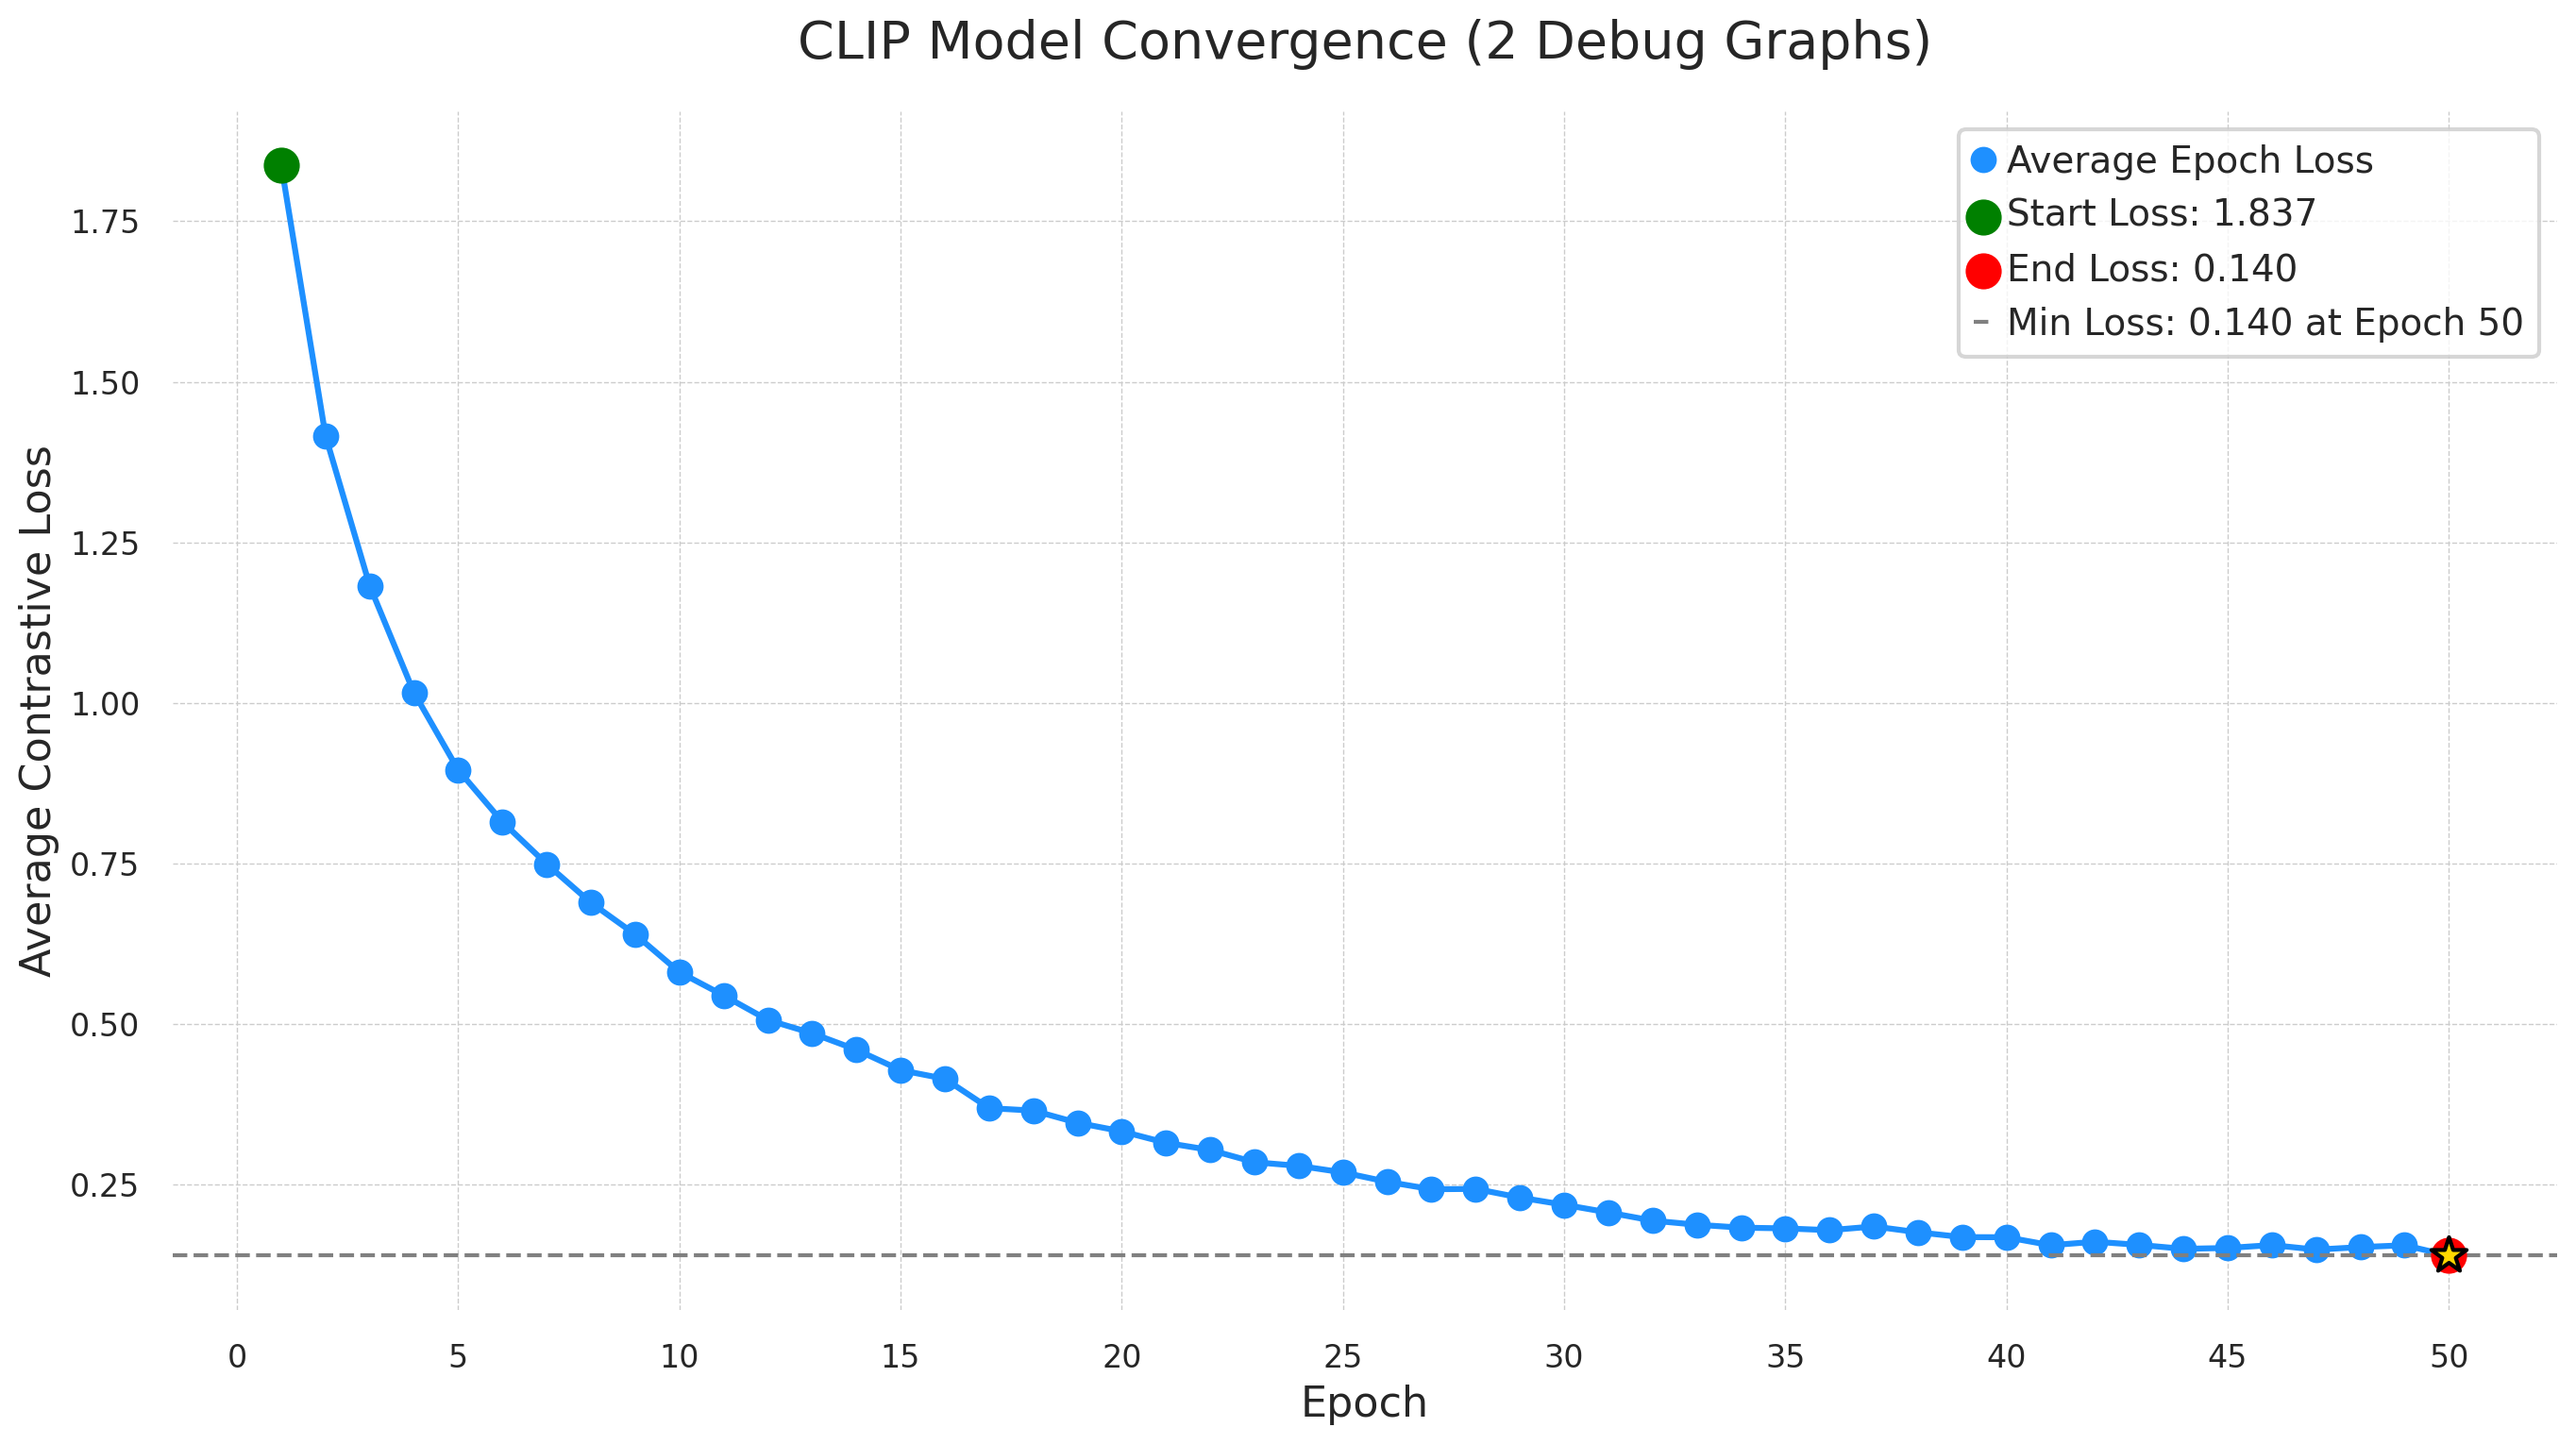

In [168]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_training_loss(epochs, avg_losses, title=None, save_path=None):
    """
    Visualizes the training loss curve with professional styling.

    Args:
        epochs (list or np.array): A list of epoch numbers (e.g., [1, 2, ..., 50]).
        avg_losses (list or np.array): A list of average loss values corresponding to each epoch.
        title (str, optional): The title of the plot. Defaults to a descriptive title.
        save_path (str, optional): If provided, the plot will be saved to this file path.
                                   Example: 'training_loss.png'.
    """
    if len(epochs) != len(avg_losses):
        raise ValueError("The length of epochs and avg_losses must be the same.")

    # --- Plot Styling ---
    # Using seaborn for a cleaner, more modern look.
    sns.set_theme(style="whitegrid", context="talk")
    plt.figure(figsize=(14, 8))

    # --- Plotting the Data ---
    # Plot the main loss curve
    plt.plot(epochs, avg_losses, marker='o', linestyle='-', color='dodgerblue',
             label='Average Epoch Loss', zorder=2)

    # --- Adding Informative Annotations ---
    # Highlight the starting and ending points
    start_loss = avg_losses[0]
    end_loss = avg_losses[-1]
    plt.scatter(epochs[0], start_loss, color='green', s=150, zorder=3, label=f'Start Loss: {start_loss:.3f}')
    plt.scatter(epochs[-1], end_loss, color='red', s=150, zorder=3, label=f'End Loss: {end_loss:.3f}')

    # Find and highlight the minimum loss
    min_loss_val = min(avg_losses)
    min_loss_epoch = epochs[avg_losses.index(min_loss_val)]
    plt.axhline(y=min_loss_val, color='grey', linestyle='--', linewidth=1.5,
                label=f'Min Loss: {min_loss_val:.3f} at Epoch {min_loss_epoch}')
    plt.scatter(min_loss_epoch, min_loss_val, color='gold', s=200, marker='*',
                edgecolor='black', zorder=4)

    # --- Labels, Title, and Grid ---
    plt.xlabel("Epoch", fontsize=16)
    plt.ylabel("Average Contrastive Loss", fontsize=16)
    
    if title is None:
        title = "CLIP Model Training Convergence"
    plt.title(title, fontsize=20, pad=20)
    
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    
    # Improve the x-axis ticks for better readability if there are many epochs
    if len(epochs) > 20:
        plt.xticks(np.arange(0, max(epochs)+1, 5)) # Ticks every 5 epochs
    
    plt.legend(fontsize=14)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    
    # --- Final Touches ---
    sns.despine(left=True, bottom=True) # Remove top and right spines
    plt.tight_layout()

    # --- Save and Show ---
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Plot saved to {save_path}")

    plt.show()


# --- Main execution block ---
if __name__ == '__main__':
    # 1. Data extracted from your training log
    epochs_data = list(range(1, 51))
    avg_losses_data = [
        1.836973, 1.415864, 1.182202, 1.015899, 0.895723, 0.814881, 0.749284, 0.689129,
        0.639716, 0.581021, 0.544710, 0.506472, 0.485844, 0.460233, 0.428412, 0.414953,
        0.369296, 0.365417, 0.346427, 0.333143, 0.315249, 0.304089, 0.285087, 0.279404,
        0.269203, 0.254580, 0.243020, 0.243521, 0.230035, 0.218832, 0.206822, 0.194104,
        0.187749, 0.183197, 0.182070, 0.179256, 0.185062, 0.175994, 0.168445, 0.168267,
        0.155811, 0.161267, 0.156357, 0.150209, 0.151531, 0.156095, 0.148974, 0.152913,
        0.155773, 0.139635
    ]

    # 2. Call the function to generate and display the plot
    plot_training_loss(
        epochs=epochs_data, 
        avg_losses=avg_losses_data,
        title="CLIP Model Convergence (2 Debug Graphs)",
        save_path="debug_training_loss_curve.png"
    )